In [1]:
import numpy as np
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Lista de temporadas analizadas:
seasons = [str(x) + '-' + str(x+1) for x in range(2003, 2023)]

# Lista de rutas a archivos de cada temporada:
seasons_path = ['datasets/' + season + '.csv' for season in seasons]

# Diccionario temporada:ruta
seasons_dict = dict(zip(seasons, seasons_path))

for season, season_path in seasons_dict.items():
    # Importar datos de cada temporada al diccionario, utilizando la biblioteca Polars:
    seasons_dict[season] = pl.read_csv(season_path, truncate_ragged_lines=True, encoding='ISO-8859-1')

    # Eliminar las filas que puedan contener todos sus valores nulos:
    seasons_dict[season] = seasons_dict[season].filter(~pl.all_horizontal(pl.all().is_null()))

    # Agregar una columna 'Season':
    seasons_dict[season] = seasons_dict[season].with_columns(pl.lit(season).alias('Season'))

Los datos de cada partido fueron recopilados *illo tempore*, es decir, en el momento que se disputaban. Aunque existe consistencia entre los datos recopilados a lo largo de 20 años, con el paso de las temporadas, se agregaron nuevas variables. Por este motivo, existen diferencias entre los conjuntos de datos.

Por estos motivos y con la finalidad de analizar los datos de todas las temporadas de forma conjunta, es necesario crear un esquema unificado. Este esquema consolidará las columnas comunes entre todos los datasets y devolverá un único dataframe que incluya todas las temporadas.

In [8]:
# Crear una lista de listas de las columnas de cada dataset:
datasets_columns_list = []

for season_df in seasons_dict.values():
    datasets_columns_list.append(season_df.columns)

# Convertir cada lista de columnas en un conjunto: 
list_of_columns_sets = map(set, datasets_columns_list)

# Obtener listado de columnas comunes en todos los datasets:
from functools import reduce
common_columns_list = reduce(set.intersection, list_of_columns_sets)

# Ordenar lista de columnas basado en uno de los DataFrames:
common_columns_list = sorted(common_columns_list, key=lambda x: seasons_dict[seasons[0]].columns.index(x))

# Crear un diccionario de los datasets bajo criterio de variables unificado:
common_columns_datasets_dict = {season:season_df[common_columns_list] for season, season_df in seasons_dict.items()}

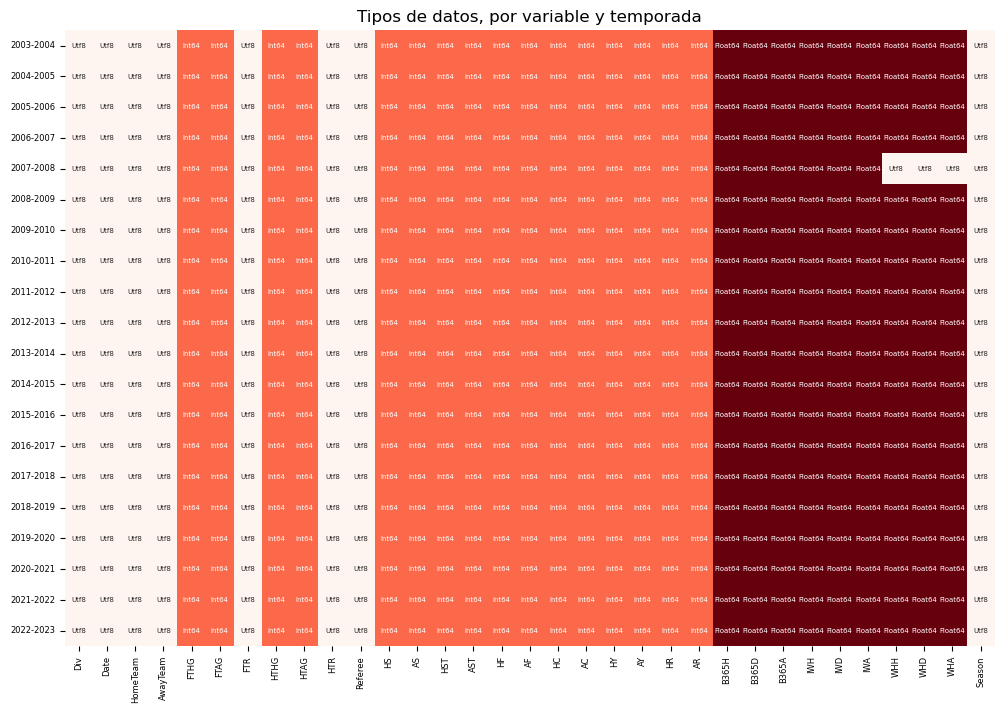

In [9]:
import pandas as pd

# Crear un diccionario que contenga los dtypes de cada DataFrame:
dtypes_dict = {season:season_df.dtypes for season, season_df in common_columns_datasets_dict.items()}

# Convertir el diccionario en un DataFrame de Polars
dtypes_df = pd.DataFrame(dtypes_dict)

dtypes_df = dtypes_df.transpose()
dtypes_df.columns = common_columns_list
dtypes_df = dtypes_df.astype('str')

# Crear un mapeo de tipos de datos a valores numéricos
datatype_mapping = {'Utf8': 0, 'Int64': 1, 'Float64': 2}

mapped_dtypes_df = dtypes_df.copy()

for col in mapped_dtypes_df.columns:
    mapped_dtypes_df[col] = mapped_dtypes_df[col].replace(datatype_mapping)
    
# Crear un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mapped_dtypes_df, annot=dtypes_df, fmt="s", cmap="Reds", cbar=False, annot_kws={"size": 5})
plt.xticks(size=6)
plt.yticks(size=6)
plt.title("Tipos de datos, por variable y temporada")
plt.show()

In [10]:
# Convertir columnas a tipos de datos correctos:
common_columns_datasets_dict['2007-2008'] = common_columns_datasets_dict['2007-2008'].with_columns([
    pl.col('WHH', 'WHD', 'WHA').cast(pl.Float64)
    ])

In [20]:
# Realizar la unión vertical de los DataFrames usando pl.DataFrame.vstack()
df = pl.DataFrame()
for season_df in common_columns_datasets_dict.values():
    df = df.vstack(season_df)

# Convertir la columna "Date" a formato fecha:
df = df.with_columns(
    pl.coalesce(
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%y", strict=False),  # para strings "dd/mm/yy"
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%Y", strict=False)   # para strings "dd/mm/yyyy"
        )
    )

# Eliminar columnas innecesarias:
df = df.drop(["Div", "Referee"])

# Mover la columna 'Season' al inicio del DataFrame:
columns = ['Season'] + [col for col in df.columns if col != 'Season']
df = df.select(columns)

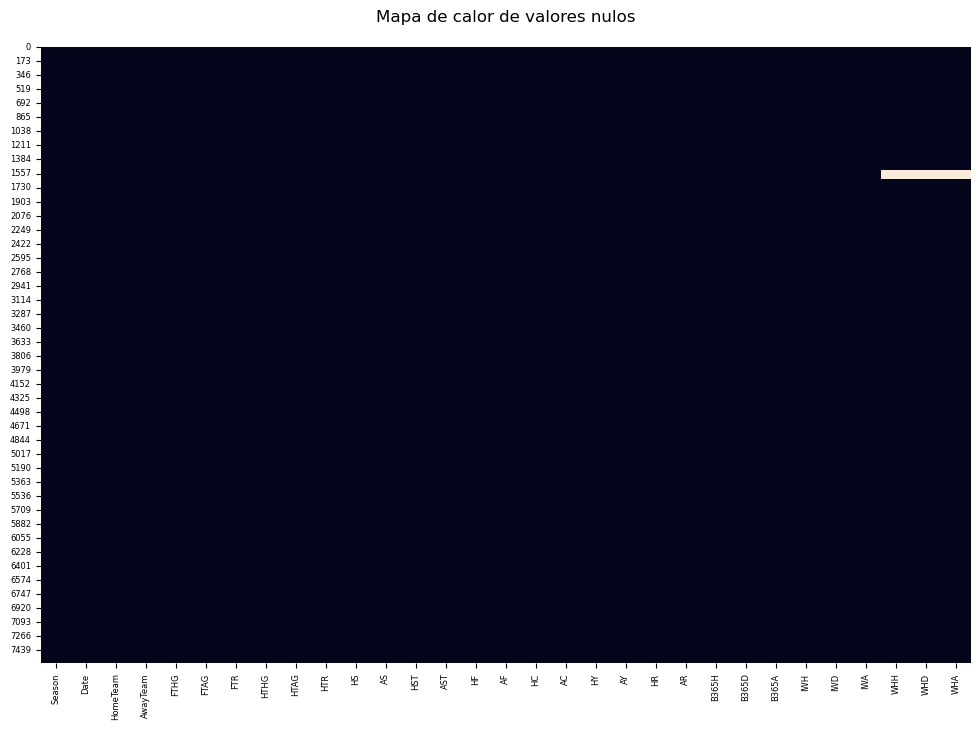

In [24]:
# Crear un DataFrame de booleanos para valores nulos 
nulls_dict = {col:df.select(pl.col(col).is_null()).to_series() for col in df.columns}
nulls_df = pd.DataFrame(nulls_dict)

plt.figure(figsize=(12, 8))
sns.heatmap(nulls_df, cbar=False)
plt.title('Mapa de calor de valores nulos\n', fontsize=12)
plt.xticks(size=6)
plt.yticks(size=6)
plt.show()

In [22]:
print(df)

shape: (7_600, 31)
┌───────────┬────────────┬─────────────┬───────────────┬───┬──────┬──────┬──────┬──────┐
│ Season    ┆ Date       ┆ HomeTeam    ┆ AwayTeam      ┆ … ┆ IWA  ┆ WHH  ┆ WHD  ┆ WHA  │
│ ---       ┆ ---        ┆ ---         ┆ ---           ┆   ┆ ---  ┆ ---  ┆ ---  ┆ ---  │
│ str       ┆ date       ┆ str         ┆ str           ┆   ┆ f64  ┆ f64  ┆ f64  ┆ f64  │
╞═══════════╪════════════╪═════════════╪═══════════════╪═══╪══════╪══════╪══════╪══════╡
│ 2003-2004 ┆ 2003-08-16 ┆ Arsenal     ┆ Everton       ┆ … ┆ 7.0  ┆ 1.28 ┆ 4.5  ┆ 8.0  │
│ 2003-2004 ┆ 2003-08-16 ┆ Birmingham  ┆ Tottenham     ┆ … ┆ 2.5  ┆ 2.2  ┆ 3.2  ┆ 2.8  │
│ 2003-2004 ┆ 2003-08-16 ┆ Blackburn   ┆ Wolves        ┆ … ┆ 4.2  ┆ 1.57 ┆ 3.5  ┆ 5.0  │
│ 2003-2004 ┆ 2003-08-16 ┆ Fulham      ┆ Middlesbrough ┆ … ┆ 3.0  ┆ 2.3  ┆ 3.2  ┆ 2.62 │
│ …         ┆ …          ┆ …           ┆ …             ┆ … ┆ …    ┆ …    ┆ …    ┆ …    │
│ 2022-2023 ┆ 2023-05-28 ┆ Leeds       ┆ Tottenham     ┆ … ┆ 2.45 ┆ 2.6  ┆ 3.5  ┆ 2.2  │
│ 